In [ ]:
import torch
TORCH = torch.__version__.split('+')[0]
CUDA = 'cu' + torch.version.cuda.replace('.','')
print(TORCH, CUDA)

import pickle
import os

2.4.1 cu121


In [ ]:
%%capture
!pip install pyg_lib -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-scatter     -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-geometric

In [ ]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from scipy.linalg import fractional_matrix_power
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib.cm as cm

from tqdm import tqdm

import math
from numba import cuda
import numpy as np
import torch
from torch_geometric.utils import (
    to_networkx,
    from_networkx,
    to_dense_adj,
    remove_self_loops,
    to_undirected,
)

import torch
import scipy.io as sio
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
torch.set_default_device('cuda')

# Set up Functions

In [ ]:
# Throughout this we are going to assume that data is of the form B x N x D
# Where B is the batch size, N is the sequence length for the transformer
# this the number of data points. Finally D is the embedding dimension.
class SimpleAttention(nn.Module):
  # Initialize the parameter
  def __init__(self, hidden_dim):
    super(SimpleAttention, self).__init__()
    self.linear = nn.Linear(hidden_dim, hidden_dim)
    self.WQ = nn.Linear(hidden_dim, hidden_dim, bias = False)
    self.WK = nn.Linear(hidden_dim, hidden_dim, bias = False)
    self.WV = nn.Linear(hidden_dim, hidden_dim, bias = False)
    self.skip = nn.Linear(hidden_dim, hidden_dim)
    self.attention = nn.MultiheadAttention(hidden_dim, 1, batch_first=True)

  # Forward pass
  def forward(self, input):
    Q = self.WQ(input)
    K = self.WK(input)
    V = self.WV(input)
    output_attention,_ = self.attention(Q,K,V)
    output_linear = self.linear(output_attention.relu()).relu()
    return output_linear + self.skip(input)

class SimpleTransformer(nn.Module):
# Initialize the parameter
  def __init__(self, input_dim, hidden_dim, out_dim, num_layers):
    super(SimpleTransformer, self).__init__()
    self.embed = nn.Linear(input_dim, hidden_dim)
    self.predictor = nn.Linear(hidden_dim, out_dim)
    self.AttentionLayers = []
    for i in range(num_layers):
      self.AttentionLayers.append(SimpleAttention(hidden_dim))

    self.AttentionLayers = nn.ModuleList(self.AttentionLayers)
    self.num_layers = num_layers

  # Forward pass
  def forward(self, z):
    z = self.embed(z)
    for i in range(self.num_layers):
      z = self.AttentionLayers[i](z)
    return self.predictor(z)

In [ ]:
def initialize_network(d,m):
  return torch.nn.Sequential(torch.nn.Linear(d,m, bias = False),
                             torch.nn.Sigmoid(),
                             torch.nn.Linear(m,1, bias = False))

def create_training_data(teacher_model, d, n):
  X = torch.randn(n,d)
  return X, teacher_model(X)

def train(model, X, y, num_iterations, d, m, Xtst, ytst):
  optimizer = torch.optim.SGD(model.parameters())
  thetas = torch.zeros(num_iterations+1, d+1, m)
  with torch.no_grad():
    thetas[0,:d,:] = list(model.parameters())[0].T.detach()
    thetas[0,d,:] = list(model.parameters())[1].detach()
  losses = torch.zeros(num_iterations)
  losses_tst = torch.zeros(num_iterations)
  for i in range(num_iterations):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = (y_pred - y).square().mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    with torch.no_grad():
      thetas[i+1,:d,:] = list(model.parameters())[0].T.detach()
      thetas[i+1,d,:] = list(model.parameters())[1].detach()
      losses[i] = loss.detach()
      losses_tst[i] = (ytst - model(Xtst)).square().mean().cpu().detach()

  return thetas, losses, losses_tst

def train_2(model, X, y, num_iterations, d, m):
  optimizer = torch.optim.SGD(model.parameters())
  thetas = torch.zeros(num_iterations+1, d+1, m)
  with torch.no_grad():
    thetas[0,:d,:] = list(model.parameters())[0].T.detach()
    thetas[0,d,:] = list(model.parameters())[1].detach()
  losses = torch.zeros(num_iterations)
  for i in range(num_iterations):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = (y_pred - y).square().mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    with torch.no_grad():
      thetas[i+1,:d,:] = list(model.parameters())[0].T.detach()
      thetas[i+1,d,:] = list(model.parameters())[1].detach()
      losses[i] = loss.detach()

  return thetas, losses

def train_with_transformer(model, transformer_model, num_iterations, d, m, X, y, Xtst, ytst):
  thetas = torch.zeros(num_iterations+1, d+1, m)
  theta = torch.zeros( d+1, m)

  with torch.no_grad():
    theta[:d,:] = list(model.parameters())[0].T.detach()
    theta[d,:] = list(model.parameters())[1].detach()

  thetas[0,:,:] = theta

  losses = torch.zeros(num_iterations)
  losses_tst = torch.zeros(num_iterations)

  for i in range(num_iterations):
    next_theta = transformer_model(theta.unsqueeze_(0).transpose(1,2)).transpose(1,2)[0,:,:]
    model[0].weight = torch.nn.Parameter(next_theta[:d,:].T)
    model[2].weight = torch.nn.Parameter(next_theta[d,:])
    theta = next_theta
    thetas[i+1,:,:] = theta

    with torch.no_grad():
      losses[i] = (y - model(X)).square().mean()
      losses_tst[i] = (ytst - model(Xtst)).square().mean().cpu().detach()

  return thetas, losses, losses_tst

# Creating Training Data

In [ ]:
d = 10
m = 100
n = 1000

teacher_model = initialize_network(d,m)
teacher_model.eval()
with torch.no_grad():
  Xtrn, ytrn = create_training_data(teacher_model, d, n)

In [ ]:
from tqdm.auto import tqdm

Xtrn = Xtrn.to('cuda')
ytrn = ytrn.to('cuda')

def create_mean_field_training_data(teacher_model, d, m, T, Xtrn, ytrn):
  thetas, _ = train_2(initialize_network(d,m), Xtrn, ytrn, T, d, m)
  thetas_X = thetas[:T,:,:]
  thetas_Y = thetas[1:,:,:]
  print(thetas.shape)
  for i in tqdm(range(1, 50)):
    thetas, _ = train_2(initialize_network(d,m), Xtrn, ytrn, T, d, m)
    thetas_X = torch.cat((thetas_X, thetas[:T,:,:]), dim = 0)
    thetas_Y = torch.cat((thetas_Y, thetas[1:,:,:]), dim = 0)
  return thetas_X, thetas_Y

In [ ]:
thetas_X, thetas_Y = create_mean_field_training_data(teacher_model, d, m, 500, Xtrn, ytrn)

torch.Size([501, 11, 100])


  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
thetas_X.shape, thetas_Y.shape

(torch.Size([25000, 11, 100]), torch.Size([25000, 11, 100]))

In [ ]:
p = torch.randperm(25000)
# p, thetas_X, thetas_Y, teacher_model, Xtrn, ytrn = torch.load("2-layer-mean-field-data.pt")

thetas_X_trn = thetas_X[p[:20000],:,:].cpu()
thetas_Y_trn = thetas_Y[p[:20000],:,:].cpu()

thetas_X_tst = thetas_X[p[20000:],:,:].cpu()
thetas_Y_tst = thetas_Y[p[20000:],:,:].cpu()

In [ ]:
thetas_X_trn.device

device(type='cpu')

# Train the Transformer

In [ ]:
torch.set_default_device('cpu')
train_dataset = torch.utils.data.TensorDataset(thetas_X_trn.transpose(1,2), thetas_Y_trn.transpose(1,2))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1000, shuffle = True)

In [ ]:
model_transformer = SimpleTransformer(11,512,11,5).to('cuda')

epochs = 250

optimizer_transformer = torch.optim.Adam(model_transformer.parameters(), lr = 2e-4)
scheduler_transformer = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_transformer, epochs)

for i in tqdm(range(epochs)):
  for data in train_loader:
    optimizer_transformer.zero_grad()
    X = data[0].to('cuda')
    Y = data[1].to('cuda')
    Y_pred = model_transformer(X)
    loss = torch.nn.functional.mse_loss(Y_pred, Y)
    loss.backward()
    optimizer_transformer.step()
  scheduler_transformer.step()
  with torch.no_grad():
    print(i, " ", loss)

In [ ]:
torch.set_default_device('cuda')

# Evaluating Model

In [ ]:
import copy

d = 10
m = 100
n = 500
num_iterations = 501

p, thetas_X, thetas_Y, teacher_model, Xtrn, ytrn = torch.load("2-layer-mean-field-data.pt")
model_transformer = torch.load("mean-field-transformer.pt")

teacher_model.eval().to('cuda')

with torch.no_grad():
  Xtst, ytst = create_training_data(teacher_model, d, n)

# thetas_X_trn = thetas_X[p[:20000],:,:]
# thetas_Y_trn = thetas_Y[p[:20000],:,:]

# thetas_X_tst = thetas_X[p[20000:],:,:]
# thetas_Y_tst = thetas_Y[p[20000:],:,:]

model = initialize_network(d,m)

T = 1

losses_sgd = torch.zeros(T,num_iterations)
losses_tst_sgd = torch.zeros(T,num_iterations)

losses_transformer = torch.zeros(T,num_iterations)
losses_tst_transformer = torch.zeros(T,num_iterations)

theta_diff = torch.zeros(T,num_iterations).cpu()

model_transformer.eval()

Xtrn = Xtrn.to('cuda')
ytrn = ytrn.to('cuda')
Xtst = Xtst.to('cuda')
ytst = ytst.to('cuda')


for i in tqdm(range(T)):
  model = initialize_network(d,m)

  thetas_sgd, losses_sgd[i,:], losses_tst_sgd[i,:] = train(copy.deepcopy(model), Xtrn, ytrn, num_iterations, d, m, Xtst, ytst)
  thetas_transformer, losses_transformer[i,:], losses_tst_transformer[i,:] = train_with_transformer(copy.deepcopy(model), model_transformer, num_iterations, d, m, Xtrn, ytrn, Xtst, ytst)

  theta_diff[i,:] = (thetas_sgd - thetas_transformer).square().mean(dim = (1,2))[1:].cpu().detach()

<ipython-input-16-c13efd966913>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  p, thetas_X, thetas_Y, teacher_model, Xtrn, ytrn = torch.load("2-layer-mean-field-data.pt")


  0%|          | 0/1 [00:00<?, ?it/s]

NameError: name 'thetas_sgd' is not defined

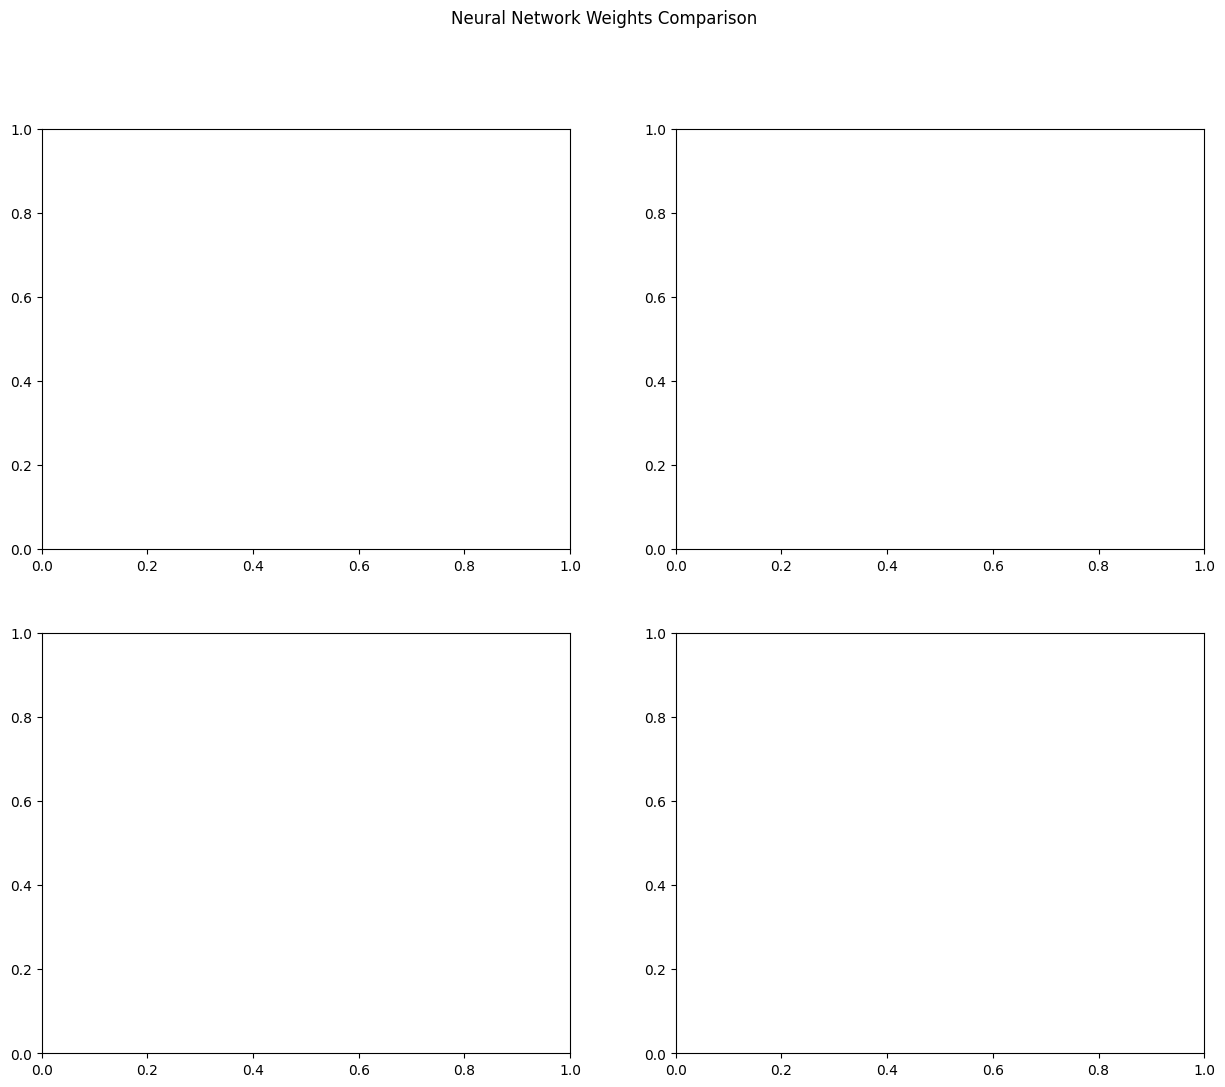

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import TwoSlopeNorm

def update_weights(theta, frame, mtype):
    if mtype == "transformer":
        return thetas_transformer[frame+1, :].reshape(d+1,m).detach().cpu()
    else:
        return thetas_sgd[frame+1, :].reshape(d+1,m).detach().cpu()

def create_heatmap(ax, data, title, vmin, vmax):
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    im = ax.imshow(data, cmap='coolwarm', norm=norm, aspect='auto')
    ax.set_title(title)
    ax.axis('off')
    return im

# Set up the figure and axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Neural Network Weights Comparison')

# Initialize weights for two networks
network1_weights = thetas_sgd[0,:].reshape(d+1,m).detach().cpu()
network2_weights = thetas_transformer[0,:].reshape(d+1,m).detach().cpu()

# Initialize change trackers
network1_total_change = torch.zeros_like(network1_weights)
network2_total_change = torch.zeros_like(network2_weights)

# Create initial heatmaps
im1 = create_heatmap(ax1, network1_weights, 'Gradient Descent - Current Weights', -0.5, 0.5)
im2 = create_heatmap(ax2, network2_weights, 'Transformer - Current Weights', -0.5, 0.5)
im3 = create_heatmap(ax3, network1_total_change, 'Gradient Descent - Total Change', -0.05, 0.05)
im4 = create_heatmap(ax4, network2_total_change, 'Transformer - Total Change', -0.05, 0.05)

# Add colorbars
cbar1 = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1)
cbar1.set_label('Weight Value')
cbar2 = fig.colorbar(im3, ax=[ax3, ax4], orientation='horizontal', pad=0.1)
cbar2.set_label('Cumulative Change in Weight')

# Animation update function
def update(frame):
    global network1_weights, network2_weights, network1_total_change, network2_total_change

    # Store previous weights
    prev_network1_weights = torch.clone(network1_weights)
    prev_network2_weights = torch.clone(network2_weights)

    # Update weights
    network1_weights = update_weights(network1_weights, frame, "sgd")
    network2_weights = update_weights(network2_weights, frame, "transformer")

    # Calculate and accumulate changes
    network1_change = network1_weights - prev_network1_weights
    network2_change = network2_weights - prev_network2_weights
    network1_total_change += network1_change
    network2_total_change += network2_change

    # Update heatmaps
    im1.set_array(network1_weights)
    im2.set_array(network2_weights)
    im3.set_array(network1_total_change)
    im4.set_array(network2_total_change)

    # Update title with current epoch
    fig.suptitle(f'Neural Network Weights Comparison - Epoch {frame}')

    # Return all artists that were modified
    return im1, im2, im3, im4

# Create the animation
anim = animation.FuncAnimation(fig, update, frames=500, interval=200, blit=False)

# Save the animation as a video file
anim.save('neural_network_weights_comparison_enhanced.mp4', writer='ffmpeg', fps=20)

plt.close(fig)
print("Video saved as 'neural_network_weights_comparison_enhanced.mp4'")

In [ ]:
losses_sgd = losses_sgd.cpu().detach()
losses_tst_sgd = losses_tst_sgd.cpu().detach()
losses_transformer = losses_transformer.cpu().detach()
losses_tst_transformer = losses_tst_transformer.cpu().detach()
theta_diff = theta_diff.cpu().detach()

# Plotting

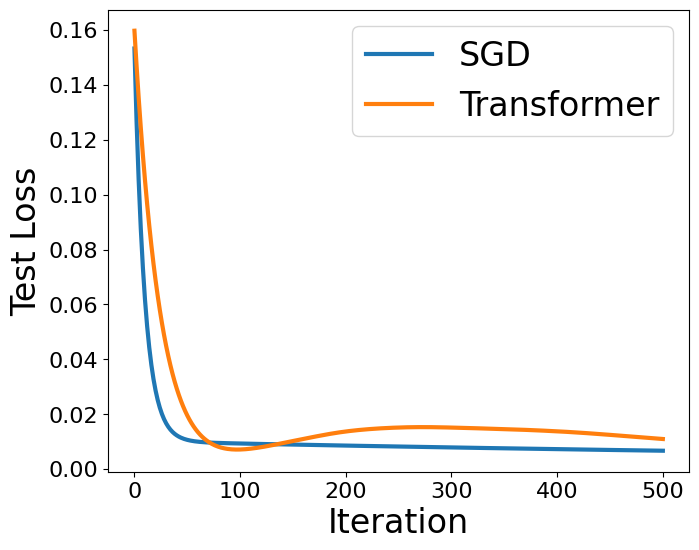

In [ ]:
fig, ax = plt.subplots(figsize = (7.5,6))

plt.plot(losses_tst_sgd.quantile(0.5, dim = 0), label = "SGD", linewidth = 3)
plt.plot(losses_tst_transformer.quantile(0.5, dim = 0), label = "Transformer", linewidth = 3)

plt.fill_between(range(num_iterations), losses_tst_sgd.quantile(0.25, dim = 0), losses_tst_sgd.quantile(0.75, dim = 0), alpha = 0.5)
plt.fill_between(range(num_iterations), losses_tst_transformer.quantile(0.25, dim = 0), losses_tst_transformer.quantile(0.75, dim = 0), alpha = 0.5)

plt.xlabel("Iteration", fontsize = 24)
plt.ylabel("Test Loss", fontsize = 24)
plt.legend(fontsize = 24)
# plt.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))
plt.tick_params(axis='both', which='major', labelsize=16)
# plt.yscale("log")
plt.savefig("mean-field-test-loss.pdf", bbox_inches = "tight", dpi = 100)

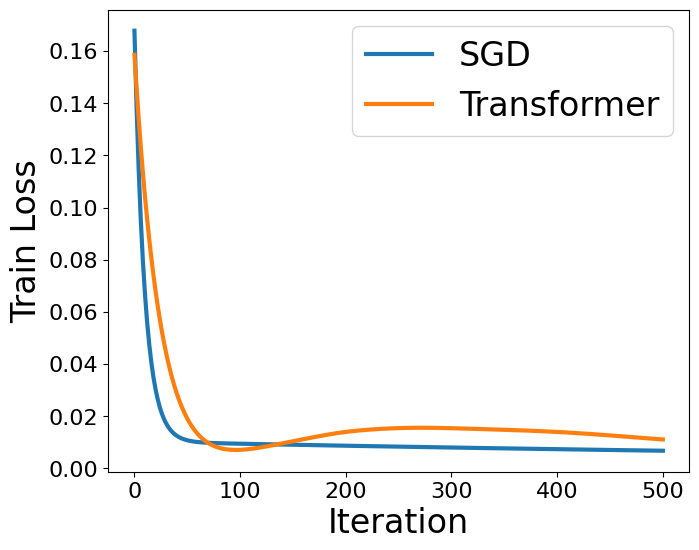

In [ ]:
fig, ax = plt.subplots(figsize = (7.5,6))

plt.plot(losses_sgd.quantile(0.5, dim = 0), label = "SGD", linewidth = 3)
plt.plot(losses_transformer.quantile(0.5, dim = 0), label = "Transformer", linewidth = 3)

plt.fill_between(range(num_iterations), losses_sgd.quantile(0.25, dim = 0), losses_sgd.quantile(0.75, dim = 0), alpha = 0.5)
plt.fill_between(range(num_iterations), losses_transformer.quantile(0.25, dim = 0), losses_transformer.quantile(0.75, dim = 0), alpha = 0.5)

plt.xlabel("Iteration", fontsize = 24)
plt.ylabel("Train Loss", fontsize = 24)
plt.legend(fontsize = 24)
# plt.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))
plt.tick_params(axis='both', which='major', labelsize=16)
# plt.yscale("log")
plt.savefig("mean-field-training-loss.pdf", bbox_inches = "tight", dpi = 100)

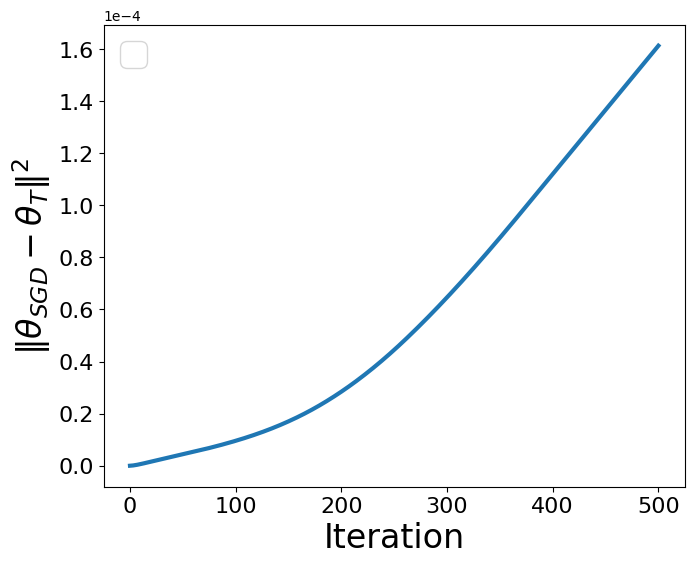

In [ ]:
fig, ax = plt.subplots(figsize = (7.5,6))

plt.plot(theta_diff.quantile(0.5, dim = 0), linewidth = 3)
plt.fill_between(range(num_iterations), theta_diff.quantile(0.25, dim = 0), theta_diff.quantile(0.75, dim = 0), alpha = 0.5)

plt.xlabel("Iteration", fontsize = 24)
plt.ylabel(r"$\|\theta_{SGD} - \theta_{T}\|^2$", fontsize = 24)

plt.legend(fontsize = 24)
plt.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig("mean-field-thetas.pdf", bbox_inches = "tight", dpi = 100)